Itération 1/100, Meilleur Score: 47.645627899190416
Itération 2/100, Meilleur Score: 49.330134186031444
Itération 3/100, Meilleur Score: 49.330134186031444
Itération 4/100, Meilleur Score: 49.330134186031444
Itération 5/100, Meilleur Score: 49.330134186031444
Itération 6/100, Meilleur Score: 50.64553436721386
Itération 7/100, Meilleur Score: 50.64553436721386
Itération 8/100, Meilleur Score: 50.64553436721386
Itération 9/100, Meilleur Score: 50.64553436721386
Itération 10/100, Meilleur Score: 50.64553436721386
Itération 11/100, Meilleur Score: 50.64553436721386
Itération 12/100, Meilleur Score: 50.64553436721386
Itération 13/100, Meilleur Score: 50.64553436721386
Itération 14/100, Meilleur Score: 50.64553436721386
Itération 15/100, Meilleur Score: 50.64553436721386
Itération 16/100, Meilleur Score: 50.64553436721386
Itération 17/100, Meilleur Score: 50.64553436721386
Itération 18/100, Meilleur Score: 50.64553436721386
Itération 19/100, Meilleur Score: 50.64553436721386
Itération 20/100

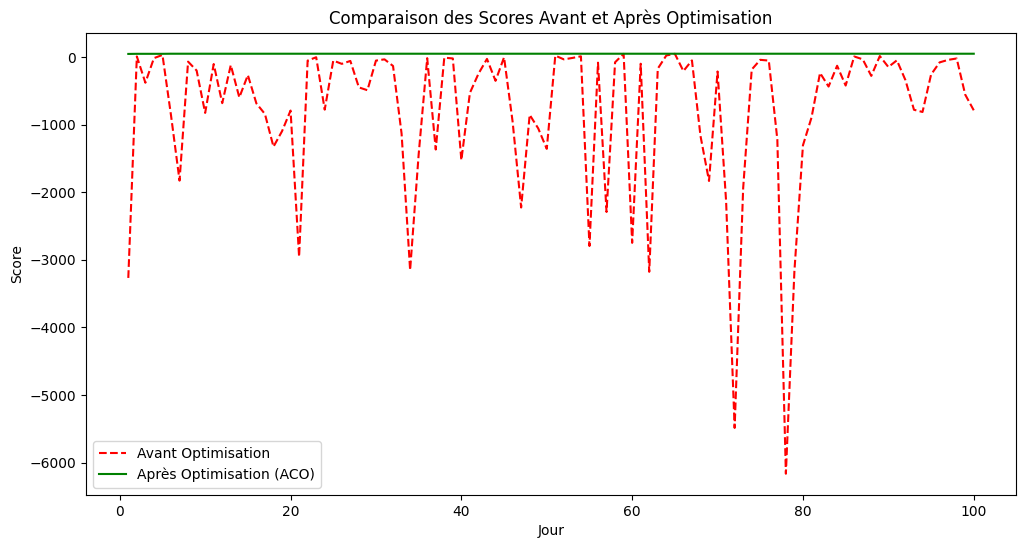

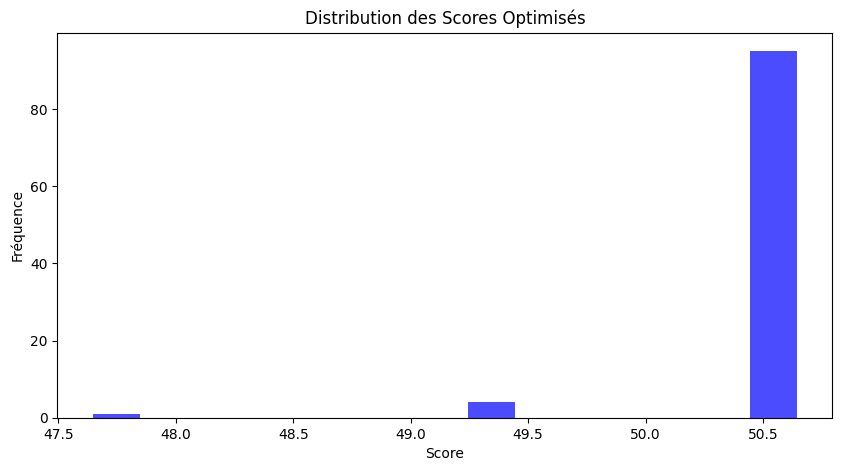

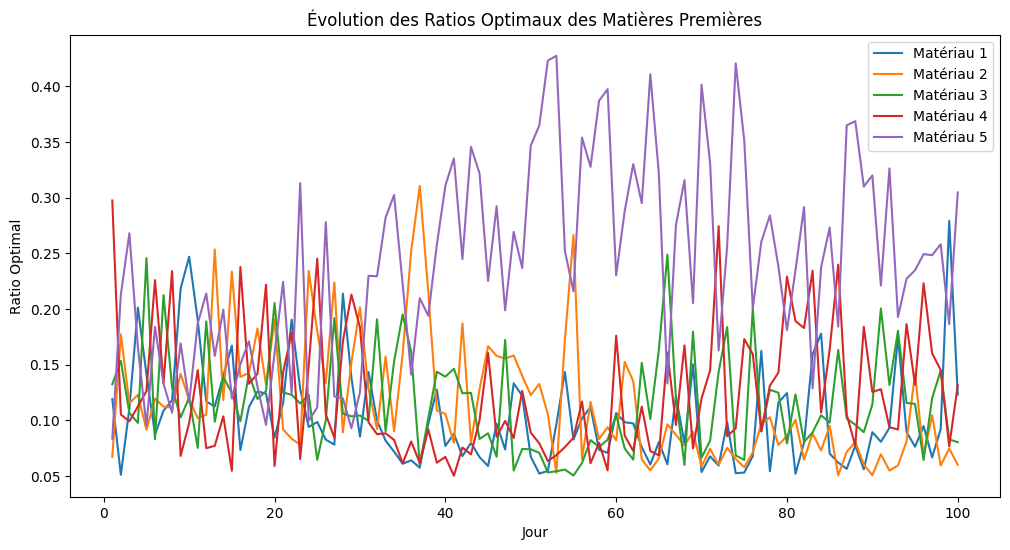

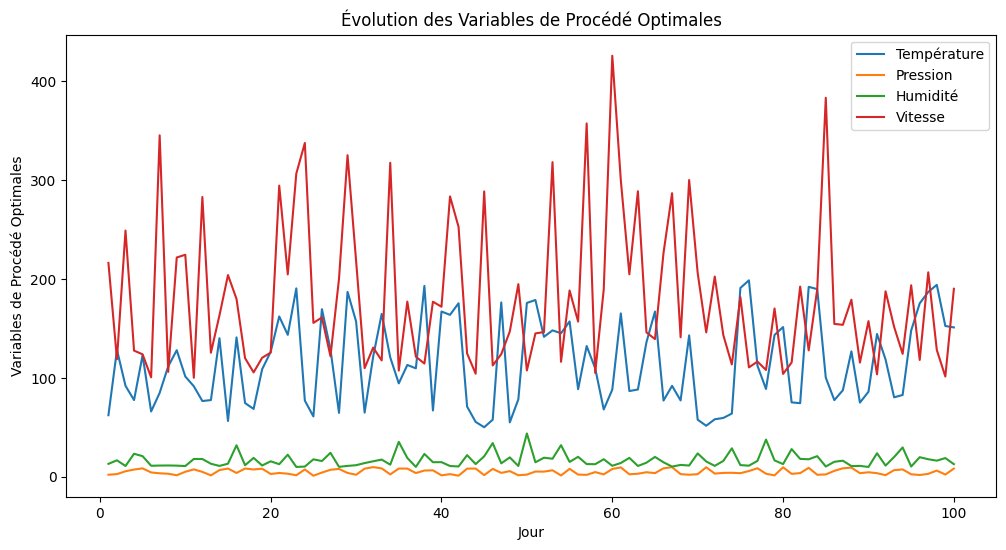

In [25]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Paramètres de simulation
nombre_fourmis = 50
nombre_itérations = 100
taux_évaporation = 0.4
alpha = 1.5  # Influence des phéromones
beta = 2.5   # Influence de la désirabilité
nombre_matériaux = 5  # Augmentation du nombre de matières premières
ratio_min, ratio_max = 0.05, 0.5  # Ajustement des limites des ratios
température_min, température_max = 50, 200
pression_min, pression_max = 1, 10

# Variables de procédé additionnelles
humidité_min, humidité_max = 10, 90
vitesse_min, vitesse_max = 100, 1000

# Paramètres pour la complexité
coûts_matières_premières_moy = np.array([5, 10, 8, 7, 12])
coûts_matières_premières_std = np.array([0.5, 0.8, 0.6, 0.7, 1.0])

efficacité_énergétique = lambda T, P: 1 - (T / température_max) * 0.1 - (P / pression_max) * 0.05

contraintes_ratios = np.array([0.15, 0.2, 0.25, 0.2, 0.2])

niveaux_phéromones = np.ones((nombre_matériaux + 4,)) * np.random.uniform(0.8, 1.2)

jours = np.arange(1, nombre_itérations + 1)
historique_coûts_matières = pd.DataFrame({
    'Jour': jours,
    'Matériau_1': np.random.normal(coûts_matières_premières_moy[0], coûts_matières_premières_std[0], nombre_itérations),
    'Matériau_2': np.random.normal(coûts_matières_premières_moy[1], coûts_matières_premières_std[1], nombre_itérations),
    'Matériau_3': np.random.normal(coûts_matières_premières_moy[2], coûts_matières_premières_std[2], nombre_itérations),
    'Matériau_4': np.random.normal(coûts_matières_premières_moy[3], coûts_matières_premières_std[3], nombre_itérations),
    'Matériau_5': np.random.normal(coûts_matières_premières_moy[4], coûts_matières_premières_std[4], nombre_itérations)
})

# Fonction de calcul du coût de production
def coût_production(variables, jour):
    ratios = np.array(variables[:nombre_matériaux])  # Ensure ratios is a numpy array
    température = variables[nombre_matériaux]
    pression = variables[nombre_matériaux + 1]
    humidité = variables[nombre_matériaux + 2]
    vitesse = variables[nombre_matériaux + 3]
    
    coûts_matières = historique_coûts_matières.loc[historique_coûts_matières['Jour'] == jour, [f'Matériau_{i+1}' for i in range(nombre_matériaux)]].values[0]
    coût_matières_premières = np.sum(ratios * coûts_matières)
    
    efficacité = efficacité_énergétique(température, pression)
    coût_énergie = (température * 0.2 + pression * 0.5 + vitesse * 0.1) / efficacité
    
    impact_environnemental = np.sum(ratios ** 2) * 10
    coût_maintenance = (vitesse / vitesse_max) * (humidité / humidité_max) * 100
    
    coût_total = coût_matières_premières + coût_énergie + impact_environnemental + coût_maintenance
    return coût_total

# Fonction de calcul de la qualité du produit
def qualité_produit(variables):
    ratios = np.array(variables[:nombre_matériaux])  # Ensure ratios is a numpy array
    température = variables[nombre_matériaux]
    pression = variables[nombre_matériaux + 1]
    humidité = variables[nombre_matériaux + 2]
    vitesse = variables[nombre_matériaux + 3]
    
    écart_ratios = np.sum((ratios - contraintes_ratios) ** 2)
    stabilité_processus = np.exp(-écart_ratios)
    performance = (température / température_max) * (pression / pression_max) * (humidité / humidité_max) * (vitesse / vitesse_max)
    termes_interaction = (température * pression) + (humidité * vitesse) + (ratios[0] * ratios[1]) + (ratios[2] * ratios[3])
    
    qualité = stabilité_processus * performance + 0.001 * termes_interaction
    return qualité

# Fonction objectif modifiée pour obtenir des scores positifs
def fonction_objectif(variables, jour, poids_qualité=0.8, poids_coût=0.2):
    coût = coût_production(variables, jour)
    qualité = qualité_produit(variables)
    
    # Niveau de qualité souhaité
    qualité_cible = 1.0
    écart_qualité = (qualité_cible - qualité) ** 2  # Pénalité quadratique pour l'écart de qualité
    
    # Normalisation du coût
    coût_normalisé = coût / 1000  # Diviser par un coût maximal estimé pour normaliser
    
    # Calcul du score avec les poids ajustés
    score = poids_qualité * (qualité_cible - écart_qualité) - poids_coût * coût_normalisé
    
    # Ajouter une constante positive pour garantir des scores positifs
    score += 50  # Ajuster la valeur selon les besoins
    
    return score

# ... [reste du code inchangé pour exécution et visualisation] ...


scores_aléatoires = []
for jour in jours:
    variables = []
    ratios = np.random.dirichlet(np.ones(nombre_matériaux), size=1)[0]
    ratios = ratios * (ratio_max - ratio_min) + ratio_min
    variables.extend(ratios)
    variables.append(np.random.uniform(température_min, température_max))
    variables.append(np.random.uniform(pression_min, pression_max))
    variables.append(np.random.uniform(humidité_min, humidité_max))
    variables.append(np.random.uniform(vitesse_min, vitesse_max))
    
    score = fonction_objectif(variables, jour)
    scores_aléatoires.append(score)

meilleurs_scores = []
meilleure_solution = None
meilleur_score = -np.inf

variables_optimales = []

for itération, jour in enumerate(jours):
    solutions = []
    scores = []
    
    for fourmi in range(nombre_fourmis):
        ratios = np.random.dirichlet(niveaux_phéromones[:nombre_matériaux] ** alpha, size=1)[0]
        ratios = ratios * (ratio_max - ratio_min) + ratio_min
        
        if not np.all((ratios >= ratio_min) & (ratios <= ratio_max)):
            continue
        
        température = np.random.uniform(température_min, température_max)
        pression = np.random.uniform(pression_min, pression_max)
        humidité = np.random.uniform(humidité_min, humidité_max)
        vitesse = np.random.uniform(vitesse_min, vitesse_max)
        
        variables = []
        variables.extend(ratios)
        variables.extend([température, pression, humidité, vitesse])
        
        score = fonction_objectif(variables, jour)
        
        solutions.append(variables)
        scores.append(score)
    
    if scores:
        meilleur_idx = np.argmax(scores)
        meilleur_score_itération = scores[meilleur_idx]
        meilleure_solution_itération = solutions[meilleur_idx]
        
        if meilleur_score_itération > meilleur_score:
            meilleur_score = meilleur_score_itération
            meilleure_solution = meilleure_solution_itération + [jour]
        
        meilleurs_scores.append(meilleur_score)
        variables_optimales.append(meilleure_solution_itération)
        
        niveaux_phéromones *= (1 - taux_évaporation)
        indices_meilleurs = np.argsort(scores)[-5:]
        for idx in indices_meilleurs:
            vars = solutions[idx]
            niveaux_phéromones[:nombre_matériaux] += vars[:nombre_matériaux]
            niveaux_phéromones[nombre_matériaux] += vars[nombre_matériaux] / température_max
            niveaux_phéromones[nombre_matériaux + 1] += vars[nombre_matériaux + 1] / pression_max
            niveaux_phéromones[nombre_matériaux + 2] += vars[nombre_matériaux + 2] / humidité_max
            niveaux_phéromones[nombre_matériaux + 3] += vars[nombre_matériaux + 3] / vitesse_max
        
        print(f"Itération {itération + 1}/{nombre_itérations}, Meilleur Score: {meilleur_score}")
    else:
        meilleurs_scores.append(meilleur_score)
        if variables_optimales:
            variables_optimales.append(variables_optimales[-1])
        else:
            variables_optimales.append([0] * (nombre_matériaux + 4))
        print(f"Itération {itération + 1}/{nombre_itérations}, Aucune solution valide trouvée.")

variables_optimales = np.array(variables_optimales)

print("\nMeilleure solution trouvée après optimisation :")
print(f"Jour : {meilleure_solution[-1]}")
print("Ratios des matières premières :", meilleure_solution[:nombre_matériaux])
print("Température optimale :", meilleure_solution[nombre_matériaux])
print("Pression optimale :", meilleure_solution[nombre_matériaux + 1])
print("Humidité optimale :", meilleure_solution[nombre_matériaux + 2])
print("Vitesse optimale :", meilleure_solution[nombre_matériaux + 3])
print("Meilleur Score :", meilleur_score)

plt.figure(figsize=(12, 6))
plt.plot(jours, scores_aléatoires, label="Avant Optimisation", color="red", linestyle="--")
plt.plot(jours, meilleurs_scores, label="Après Optimisation (ACO)", color="green")
plt.xlabel("Jour")
plt.ylabel("Score")
plt.title("Comparaison des Scores Avant et Après Optimisation")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(meilleurs_scores, bins=15, color='blue', alpha=0.7)
plt.title("Distribution des Scores Optimisés")
plt.xlabel("Score")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(12, 6))
for i in range(nombre_matériaux):
    plt.plot(jours, variables_optimales[:, i], label=f"Matériau {i+1}")
plt.xlabel("Jour")
plt.ylabel("Ratio Optimal")
plt.title("Évolution des Ratios Optimaux des Matières Premières")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jours, variables_optimales[:, nombre_matériaux], label="Température")
plt.plot(jours, variables_optimales[:, nombre_matériaux + 1], label="Pression")
plt.plot(jours, variables_optimales[:, nombre_matériaux + 2], label="Humidité")
plt.plot(jours, variables_optimales[:, nombre_matériaux + 3], label="Vitesse")
plt.xlabel("Jour")
plt.ylabel("Variables de Procédé Optimales")
plt.title("Évolution des Variables de Procédé Optimales")
plt.legend()
plt.show()
